# Diseño de filtros selectivos en frecuencia

En este cuaderno veremos como diseñar filtros FIR o IIR a partir de 
la respuesta en frecuencia deseada.

Los pasos que seguiremos serán:

* Especificaciones: tolerancia en banda de paso y atenuada y banda de transición.
* Obtener orden y frecuencia de corte.
   * Verificar orden 
* Obtener coeficientes
* Calcular y representar respuesta en frecuencia.
* Aplicarlo al filtrado de una señal.

En clase diseñaremos
* paso-bajo de canal telefónico. Con el que explicaremos el proceso
* Un filtro paso banda que seleccione una octava del piano
* Un filtro paso-bajo que selecciones los bajos de una melodía de piano.





In [1]:
%matplotlib inline
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from scipy import signal

#Hacer que las figuras por defecto salgan más grandes
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)


import math
import cmath

import warnings
warnings.filterwarnings('ignore')

import upv_audio

# Procedimiento de diseño
El proceso de diseño comienza con unas especificaciones analógicas. Un ejemplo sería:
* Filtro paso-bajo de frecuencia de corte 3 Khz.
* Atenuación máxima en la bada de paso: 2 dB
* Atenuación mínima en la banda atenuada: 50 dB.
* Anchura banda de transición: 500. Esto quiere decir que:
  * En el rango 0-2.75 khz tendríamos 2 dB
  * En el rango 3.25- khz tendríamos al menos 50 dBs de atenuación en todas las frecuencias.
  
A continuación se trasladan las especificaciones de frecuencia a frecuencia discreta sabiendo a qué frecuencia trabajará el filtro $f_s$  

## Diseño de un filtro paso-bajo de canal telefónico

In [2]:
fs=44100
f_paso =2750/fs # digital
f_atenuada=3250/fs # digital
print('fpaso=',f_paso)
print('faten=',f_atenuada)

fpaso= 0.06235827664399093
faten= 0.07369614512471655


El siguiente paso consiste en:
* Elegir un tipo de aproximación. En este caso elegiremos Chebyshev1
  * Se explica en clase brevemente en qué consiste esta aproximación
  * Se explica en clase otro tipo de aproximaciones que existen.
* Determinar los parámetros de la aproximación
  * Orden del filtro: número de coeficientes que necesitaremos
  * Rizado en la banda de paso. En nuestro caso 2 dB
  * Frecuencia de corte: según el tipo de aproximación es una cosa u otra. Normalmente está entre f_paso y f_atenuada.


In [3]:
# Existen funciones similares para otro tipo de filtros
orden,Wn=signal.cheb1ord(f_paso*2,f_atenuada*2,2,50)# Ojo al *2 de las frecuencias. Las atenuaciones en dBs
print(orden)

12


Con esos datos procedemos al diseño propiamente dicho:

In [4]:
B,A=signal.cheby1(orden,2,Wn,'lowpass')#Tambien se vale highpass. Si no se pone se entiende lowpass

Calcularemos y representaremos la respuesta en frecuencia para comprobar que todo OK

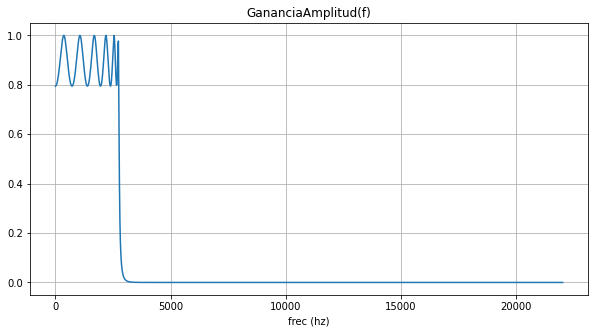

In [5]:
w,H=signal.freqz(B,A,1024)
_=plt.plot(w/2/math.pi*fs,np.absolute(H))
_=plt.grid()
_=plt.title('GananciaAmplitud(f)')
_=plt.xlabel('frec (hz)')

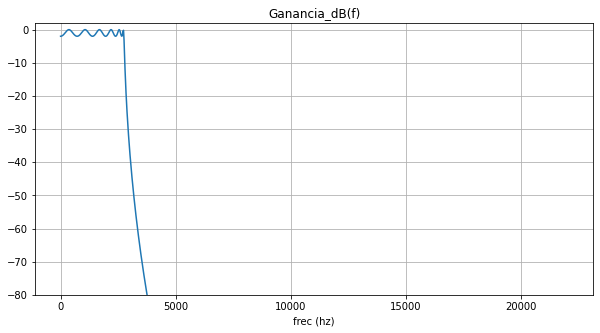

In [6]:
#Lo mismo en dBs
w,H=signal.freqz(B,A,1024)
_=plt.plot(w/2/math.pi*fs,20*np.log10(np.absolute(H)))
_=plt.grid()
_=plt.title('Ganancia_dB(f)')
_=plt.xlabel('frec (hz)')
_=plt.ylim(-80,2)

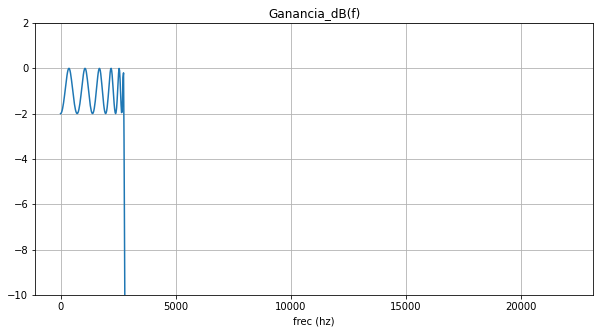

In [7]:
# Detalle banda de paso
#Lo mismo en dBs
w,H=signal.freqz(B,A,1024)
_=plt.plot(w/2/math.pi*fs,20*np.log10(np.absolute(H)))
_=plt.grid()
_=plt.title('Ganancia_dB(f)')
_=plt.xlabel('frec (hz)')
_=plt.ylim(-10,2)

De las gráficas anteriores se puede observar que:
* En la banda de paso la atenuación es de 2 dB
* A partir de 3500 hz la atenuación es mayor de 50 dB.


Finalmente emplearemos el filtro con una señal de audio a ver cómo suena:

In [9]:
fs,audio=upv_audio.read('audios/elvis_44.wav')
print (fs,audio.shape)

44100 (7967855, 2)


**IMPORTANTE**: La frecuencia de muestreo del audio debe coincidir con la del diseño. Si no, el filtrado lo hará con otra frecuencia de corte

In [10]:
filtrada = signal.lfilter(B,A,audio,axis=0)# Ojo con axis=0. Por defecto pone -1 que es el último eje!!!
print(filtrada.shape)

(7967855, 2)


In [11]:
upv_audio.write('audios_out/filtrada.wav',fs,filtrada)

**Observaciones**
Se recomienda escuchar con unos cascos (no altavoces PC)

Notar como faltan las notas  agudas


## Diseño  filtro paso-banda elíptico

Diseñaremos un filtro que deje pasar la octava 440-880 hz.

Las bandas de transición las haremos de 3 semitonos

El rizado en la banda de paso será de 1.5 dB y de 70 dB en la banda atenuada.

In [12]:
# Leemos la señal que queremos filtrar. ES IMPORTANTE la fs!!
fs,audio2=upv_audio.read('audios/nocturno_16k.wav')
print (fs,audio.shape)

16000 (7967855, 2)


In [13]:
Rp=1.5
Rs=70

fp1=440
fp2=880
fs1=440/2**(3/12)
fs2=880*2**(3/12)
fpass =np.array([fp1,fp2])
fstop=np.array([fs1,fs2])
print(fpass,fstop)

[440 880] [ 369.99442271 1046.5022612 ]


In [14]:
ordellip,Wellip=signal.ellipord(fpass*2/fs,fstop*2/fs,Rp,Rs) # Normalizar por fs y *2
print(ordellip,Wellip)
print(Rp,Rs)

6 [0.055 0.11 ]
1.5 70


In [15]:
B,A=signal.ellip(ordellip,Rp,Rs,Wellip,btype='bandpass')


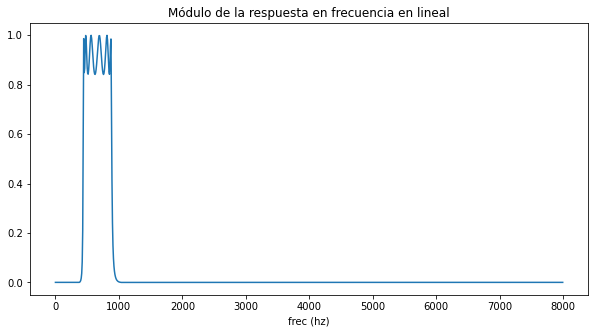

In [16]:
#Representación de la ganancia(f)
w,H3=signal.freqz(B,A,1024)
_=plt.plot(w/2/math.pi*fs,np.absolute(H3)) #insistir en eje de frecuencia
_=plt.title('Módulo de la respuesta en frecuencia en lineal')
_=plt.xlabel('frec (hz)')

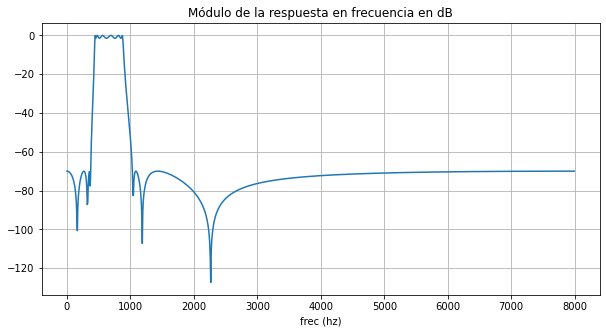

In [17]:
_=plt.plot(w/2/math.pi*fs,20*np.log10(np.absolute(H3)))
_=plt.title('Módulo de la respuesta en frecuencia en dB')
_=plt.xlabel('frec (hz)')
_=plt.grid()

In [18]:
filtrada3 = signal.lfilter(B,A, audio2,axis=0)
upv_audio.write('audios_out/nocturno_unaoctava.wav',fs,filtrada3)

Escuchar la grabación anterior.
 * Notar cómo faltan las notas más agudas
 * No tiene "bajos
 
 
## Diseño de un filtro paso-bajo para las frecuencias graves

In [19]:
Rp=1.5
Rs=80
Wp=300 #hz
Ws= 300*2**(2/12) # Dos semitonos más

In [20]:
ordellip,Wellip=signal.ellipord(Wp*2/fs,Ws*2/fs,Rp,Rs)
print(ordellip,Wellip)
print(Rp,Rs)

10 0.0375
1.5 80


In [21]:
B,A=signal.ellip(ordellip,Rp,Rs,Wellip)


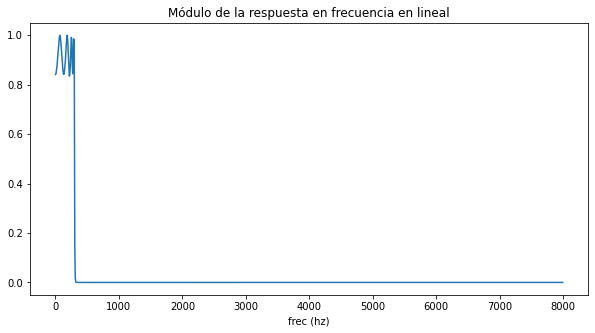

In [22]:
w,H3=signal.freqz(B,A,1024)
_=plt.plot(w/2/math.pi*fs,np.absolute(H3))
_=plt.title('Módulo de la respuesta en frecuencia en lineal')
_=plt.xlabel('frec (hz)')

In [23]:
filtrada4 = signal.lfilter(B,A, audio2,axis=0)
upv_audio.write('audios_out/nocturno_bajos.wav',fs,filtrada4)